In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
import random
from sklearn import preprocessing

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

## read train data

In [2]:

def read_train_pdb(filename):

    with open(filename, 'r') as file:
        strline_L = file.readlines()
        # print(strline_L)

    X_list = list()
    Y_list = list()
    Z_list = list()
    atomtype_list = list()
    for strline in strline_L:
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()

        line_length = len(stripped_line)
        # print("Line length:{}".format(line_length))
        if line_length < 78:
            print("ERROR: line length is different. Expected>=78, current={}".format(line_length))

        X_list.append(float(stripped_line[30:38].strip()))
        Y_list.append(float(stripped_line[38:46].strip()))
        Z_list.append(float(stripped_line[46:54].strip()))

        atomtype = stripped_line[76:78].strip()
        if atomtype == 'C':
            atomtype_list.append('h') # 'C' replaced by 'h' means hydrophobic
        else:
            atomtype_list.append('p') # rest replaced by 'p' means polar

    return X_list, Y_list, Z_list, atomtype_list



# X_list, Y_list, Z_list, atomtype_list=read_train_pdb("/content/drive/MyDrive/BS6207/Final_Project/training_data/0001_lig_cg.pdb")
# # # X_list, Y_list, Z_list, atomtype_list=read_train_pdb("training_first_100_samples/0001_pro_cg.pdb")
# # # X_list, Y_list, Z_list, atomtype_list=read_train_pdb("training_first_100_samples/0001_lig_cg.pdb")
# print(X_list)
# print(Y_list)
# print(Z_list)
# print(atomtype_list)

In [3]:
protein_train_data = []
ligand_train_data = []
# load train data into proten list and lig list

for i in range(1,3001):
    protein_train_data.append(read_train_pdb("training_data/{:04d}_pro_cg.pdb".format(i)))

for i in range(1,3001):
    ligand_train_data.append(read_train_pdb("training_data/{:04d}_lig_cg.pdb".format(i)))
ligand_train_data[0]

([35.539, 35.46, 37.468, 32.552, 32.762],
 [35.844, 37.915, 36.861, 35.15, 34.28],
 [20.035, 21.52, 18.924, 23.615, 27.112],
 ['h', 'h', 'h', 'h', 'h'])

# Read Test data

In [4]:
def read_test_pdb(filename):

    with open(filename, 'r') as file:
        strline_L = file.readlines()
        
    X_list = list()
    Y_list = list()
    Z_list = list()
    atom_list = list()
    
        
    for strline in strline_L: 
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()
        # print(stripped_line)
        splitted_line = stripped_line.split('\t')            

        X_list.append(float(splitted_line[0])),
        Y_list.append(float(splitted_line[1])),
        Z_list.append(float(splitted_line[2])),
        atom_list.append(str(splitted_line[3]))

    return X_list, Y_list, Z_list, atom_list


# X_list, Y_list, Z_list, atomtype_list=read_pdb("testing_data/0001_lig_cg.pdb")
# print(X_list)
# print(Y_list)
# print(Z_list)
# print(atomtype_list)

In [5]:
protein_test_data = []
ligand_test_data = []
# load train data into proten list and lig list

for i in range(1,825):
    protein_test_data.append(read_test_pdb("testing_data_release/testing_data/{:04d}_pro_cg.pdb".format(i)))

for i in range(1,825):
    ligand_test_data.append(read_test_pdb("testing_data_release/testing_data/{:04d}_lig_cg.pdb".format(i)))
ligand_test_data[0]

([15.362, 12.744, 7.154, 6.037, 3.632],
 [19.079, 18.548, 19.378, 18.709, 18.532],
 [-4.942, -7.661, -8.09, -8.427, -11.479],
 ['h', 'h', 'h', 'p', 'h'])

# Normalization

## normalize test data

In [212]:
# normalize the train data
# norm_lig_train[total 3000 counts][X/Y/Z][rows in one file: lig 5, prot 701]
norm_lig_train = []
norm_prot_train = []

for i in range(len(protein_train_data)):
    lig_centroid = np.expand_dims(np.mean(ligand_train_data[i][:3], axis = 1), axis = 1)
    prot_ = (np.array(np.round((protein_train_data[i][:3] - lig_centroid), decimals = 3))).tolist()
    prot_.append(protein_train_data[i][3])
    norm_prot_train.append(prot_)
    
    lig_ = (np.array(np.round((ligand_train_data[i][:3] - lig_centroid), decimals = 3))).tolist()
    lig_.append(ligand_train_data[i][3])
    norm_lig_train.append(lig_)

In [213]:
# normalize the test data attributes

norm_lig_test = []
norm_prot_test = []

for i in range(len(protein_test_data)):
    lig_centroid = np.expand_dims(np.mean(ligand_test_data[i][:3], axis = 1), axis = 1)
    prot_ = (np.array(np.round((protein_test_data[i][:3] - lig_centroid), decimals = 3))).tolist()
    prot_.append(protein_test_data[i][3])
    norm_prot_test.append(prot_)
    
    lig_ = (np.array(np.round((ligand_test_data[i][:3] - lig_centroid), decimals = 3))).tolist()
    lig_.append(ligand_test_data[i][3])
    norm_lig_test.append(lig_)

norm_test_data = {
    'proteins': norm_prot_test,
    'ligands': norm_lig_test
}

# split train into train and validation

In [214]:
# total 3000. train: 80% total, validation: 20% total

norm_train_split_data = {
    'proteins': norm_prot_train[:2400],
    'ligands': norm_lig_train[:2400]    
}

norm_valid_split_data = {
    'proteins': norm_prot_train[:600],
    'ligands': norm_lig_train[:600]
}

# check the max and min of dataset

In [215]:
# Record the maximum size of each axis to estimate the size of pairs
x_max = list()
y_max = list()
z_max = list()
x_min = list()
y_min = list()
z_min = list()

for i in range(len(norm_prot_train)):
    x_max.append(max(np.abs(norm_prot_train[i][0])))
    y_max.append(max(np.abs(norm_prot_train[i][1])))
    z_max.append(max(np.abs(norm_prot_train[i][2])))
    x_min.append(min(np.abs(norm_prot_train[i][0])))
    y_min.append(min(np.abs(norm_prot_train[i][1])))
    z_min.append(min(np.abs(norm_prot_train[i][2])))


total_size = pd.DataFrame({'max_X':x_max,'max_Y':y_max,'max_Z':z_max,'min_X':x_min,'min_Y':y_min,'min_Z':z_min})
total_size.describe()

,max_X,max_Y,max_Z,min_X,min_Y,min_Z
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,39.992332,40.369756,42.849595,0.030064,0.025421,0.031162
std,18.789359,19.764227,21.467782,0.102038,0.030708,0.060157
min,8.642000,10.116000,10.380000,0.000000,0.000000,0.000000
25%,27.066750,27.489750,28.384250,0.006000,0.006000,0.007000
50%,34.487500,34.577000,36.072000,0.016000,0.015000,0.017000
75%,47.493000,47.796250,50.304500,0.035000,0.033000,0.037000
max,282.240000,261.039000,271.938000,4.103000,0.336000,1.463000


In [81]:
len(norm_train_split_data['proteins'])

2400

## combine order pairing

In [216]:
# pairs is a 3D structure 50 x 50 x 50 pixels

def generate_order_pairing(pairing_size, normalized_training_data):
    
    pos_pairs_ = []
    scaling = 4
    shift = (pairing_size - 1 ) // 2
    
    for i in range(len(normalized_training_data['proteins'])):
        pos_pairs = torch.zeros(2,pairing_size,pairing_size,pairing_size)
        
        # Protein
        for j in range(len(normalized_training_data['proteins'][i][0])):
            
            x_p, y_p, z_p = normalized_training_data['proteins'][i][0][j], normalized_training_data['proteins'][i][1][j], normalized_training_data['proteins'][i][2][j]
            x_p, y_p, z_p = int(round(x_p/scaling + shift)), int(round(y_p/scaling + shift)), int(round(z_p/scaling + shift))
            
            # Pruning
            if x_p >= pairing_size or y_p >= pairing_size or z_p >= pairing_size or x_p < 0 or y_p < 0 or z_p < 0 :
                continue
            if pos_pairs[0,x_p,y_p,z_p] !=0 or pos_pairs[1,x_p,y_p,z_p] !=0:
                continue 
                
            # First channel
            pos_pairs[0,x_p,y_p,z_p] = -1
            
            # Second channel
            if normalized_training_data['proteins'][i][3][j] == 'h':
                pos_pairs[1,x_p,y_p,z_p] = 1
            else:
                pos_pairs[1,x_p,y_p,z_p] = -1
                
        # Ligands 
        for k in range(len(normalized_training_data['ligands'][i][0])):
            x_l, y_l, z_l = normalized_training_data['ligands'][i][0][k], normalized_training_data['ligands'][i][1][k], normalized_training_data['ligands'][i][2][k]
            x_l, y_l, z_l = int(round(x_l/scaling + shift)), int(round(y_l/scaling + shift)), int(round(z_l/scaling + shift))
            
            # Pruning
            if x_l > pairing_size or y_l > pairing_size or z_l > pairing_size or x_l < 0 or y_l < 0 or z_l < 0 :
                continue
            if pos_pairs[0,x_l,y_l,z_l] !=0 or pos_pairs[1,x_l,y_l,z_l] !=0:
                continue
            
            # First channel
            pos_pairs[0,x_l,y_l,z_l] = 1
            
            # Second channel
            if normalized_training_data['ligands'][i][3][k] == 'h':
                pos_pairs[1,x_l,y_l,z_l] = 1
            else:
                pos_pairs[1,x_l,y_l,z_l] = -1
                
        pos_pairs_.append(pos_pairs)
                
    return pos_pairs_


In [383]:
order_training_pairs = torch.stack(generate_order_pairing(25, norm_train_split_data))
order_validation_pairs = torch.stack(generate_order_pairing(25, norm_valid_split_data))
print('Shape of order_training_pairs:',order_training_pairs.shape)
print('Shape of order_validation_pairs:',order_validation_pairs.shape)

Shape of order_training_pairs: torch.Size([2400, 2, 25, 25, 25])
Shape of order_validation_pairs: torch.Size([600, 2, 25, 25, 25])


# generate disorder pairing

In [218]:
def generate_disorder_pairing(pairing_size, normalized_training_data):
    
    neg_pairs_ = []
    scaling = 4
    shift = (pairing_size - 1 ) // 2
    
    for i in range(int(len(normalized_training_data['proteins']))):
        neg_pairs = torch.zeros(2,pairing_size,pairing_size,pairing_size)
        
        # Protein
        for j in range(len(normalized_training_data['proteins'][i][0])):
            x_p, y_p, z_p = normalized_training_data['proteins'][i][0][j], normalized_training_data['proteins'][i][1][j], normalized_training_data['proteins'][i][2][j]
            x_p, y_p, z_p = int(round(x_p/scaling + shift)), int(round(y_p/scaling + shift)), int(round(z_p/scaling + shift))
            
            # Pruning
            if x_p >= pairing_size or y_p >= pairing_size or z_p >= pairing_size or x_p < 0 or y_p < 0 or z_p < 0 :
                continue
            if neg_pairs[0,x_p,y_p,z_p] !=0 or neg_pairs[1,x_p,y_p,z_p] !=0:
                continue 
                
            # First channel
            neg_pairs[0,x_p,y_p,z_p] = -1
            
            # Second channel
            if normalized_training_data['proteins'][i][3][j] == 'h':
                neg_pairs[1,x_p,y_p,z_p] = 1
            else:
                neg_pairs[1,x_p,y_p,z_p] = -1
                
        # Ligand
        choice_ = random.choice(list(range(i)) + list(range(i+1, int(len(normalized_training_data['proteins'])))))        
        for k in range(len(normalized_training_data['ligands'][choice_][0])):
            x_l, y_l, z_l = normalized_training_data['ligands'][choice_][0][k], normalized_training_data['ligands'][choice_][1][k], normalized_training_data['ligands'][choice_][2][k]
            x_l, y_l, z_l = int(round(x_l/scaling + shift)), int(round(y_l/scaling + shift)), int(round(z_l/scaling + shift))
            
            # Pruning
            if x_l > pairing_size or y_l > pairing_size or z_l > pairing_size or x_l < 0 or y_l < 0 or z_l < 0 :
                continue
            if neg_pairs[0,x_l,y_l,z_l] !=0 or neg_pairs[1,x_l,y_l,z_l] !=0:
                continue
                
            # First channel
            neg_pairs[0,x_l,y_l,z_l] = 1
            
            # Second channel
            if normalized_training_data['ligands'][choice_][3][k] == 'h':
                neg_pairs[1,x_l,y_l,z_l] = 1
            else:
                neg_pairs[1,x_l,y_l,z_l] = -1
                
        neg_pairs_.append(neg_pairs)        
             
    return neg_pairs_

In [382]:
disorder_training_pairs = torch.stack(generate_disorder_pairing(25, norm_train_split_data))
disorder_validation_pairs = torch.stack(generate_disorder_pairing(25, norm_valid_split_data))
print('Shape of disorder_training_pairs:',disorder_training_pairs.shape)
print('Shape of disorder_validation_pairs:',disorder_validation_pairs.shape)

Shape of disorder_training_pairs: torch.Size([2400, 2, 25, 25, 25])
Shape of disorder_validation_pairs: torch.Size([600, 2, 25, 25, 25])


# combine pair into train set and validation set

In [241]:
# label 1 bind, 0 not bine
# train
train_data = torch.cat((order_training_pairs,disorder_training_pairs),0)
train_labels = torch.tensor([1]*2400 + [0]*2400)

train_ok_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_ok_loader = torch.utils.data.DataLoader(train_ok_dataset, batch_size=64, shuffle=True)


In [242]:
# validation 
validation_data = torch.cat((order_validation_pairs,disorder_validation_pairs),0)
validation_labels = torch.tensor([1]*600 + [0]*600)

validation_ok_dataset = torch.utils.data.TensorDataset(validation_data, validation_labels)
validation_ok_loader = torch.utils.data.DataLoader(validation_ok_dataset, batch_size=64, shuffle=True)

# model

In [222]:
from torch.nn.modules.pooling import AdaptiveAvgPool3d

model = nn.Sequential(
    
        nn.Conv3d(2,16,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.BatchNorm3d(16),
#         nn.Conv3d(16,16,kernel_size=1,stride=1,padding=0),
#         nn.ReLU(),  
#         nn.BatchNorm3d(16),
        nn.MaxPool3d(2,2),
    
        nn.Conv3d(16,32,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.BatchNorm3d(32),
#         nn.Conv3d(32,32,kernel_size=1,stride=1,padding=0),
#         nn.ReLU(),  
#         nn.BatchNorm3d(32),
        nn.MaxPool3d(2,2),
    
        nn.Conv3d(32,64,kernel_size=3,stride=1,padding=0),
        nn.ReLU(),
        nn.BatchNorm3d(64),
#         nn.Conv3d(64,64,kernel_size=1,stride=1,padding=0),
#         nn.ReLU(),  
#         nn.BatchNorm3d(64),
        nn.MaxPool3d(2,2),


        nn.Dropout3d(0.4),
        nn.Flatten(),
        nn.Linear(64*1*1*1,1024),
        nn.Dropout3d(0.4),
        nn.Linear(1024,256),
        nn.Dropout3d(0.4),
        nn.Linear(256,2),
        nn.LogSoftmax(dim = 1)

        

        )

In [372]:
def train(model, train_loader, epoch): 
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    
    # Process in batches
    for i, (data, target) in enumerate(train_loader):
        # Set batch
        batch = i + 1
        
        # Reset the optimizer
        optimizer.zero_grad()  
        
        # forward + backward + optimize
        output = model(data)       
        loss = criterion(output, target)
        loss.backward()
        optimizer.step() 
        
        # Keep a running total
        train_loss += loss.item()       

            
    # Return average loss for the epoch
    avg_loss = train_loss / (i+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [373]:
def validation(model, validation_loader):
    
    # Switch the model to evaluation mode 
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        batch_count = 0
        
        for data, target in validation_loader:
            batch_count += 1         
            
            # Get the predicted classes for this batch
            output = model(data)    
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    validation_predict = 100. * correct / len(validation_loader.dataset)
    if validation_predict>80:
        torch.save(model, 'model_80.pt')
    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(avg_loss, correct, len(validation_loader.dataset),validation_predict))
    
    # Return average loss for the epoch
    return avg_loss, validation_predict

In [374]:
# Track metrics in these arrays
epoch_nums_ = []
training_loss_ = []
validation_loss_ = []
validation_predict_ = []

# saved_model.load_state_dict(torch.load(PATH))
# model = torch.load('model.pt')

epochs = 250
for epoch in range(1, epochs + 1):
    train_loss = train(model, train_ok_loader, epoch)
    test_loss, valid_predict = validation(model, validation_ok_loader)
    epoch_nums_.append(epoch)
    training_loss_.append(train_loss)
    validation_loss_.append(test_loss)
    validation_predict_.append(valid_predict)
    

Epoch: 1
Training set: Average loss: 0.726304
Validation set: Average loss: 0.693664, Accuracy: 602/1200 (50.17%)

Epoch: 2
Training set: Average loss: 0.717204
Validation set: Average loss: 0.692680, Accuracy: 607/1200 (50.58%)

Epoch: 3
Training set: Average loss: 0.710766
Validation set: Average loss: 0.691177, Accuracy: 627/1200 (52.25%)

Epoch: 4
Training set: Average loss: 0.707031
Validation set: Average loss: 0.691585, Accuracy: 621/1200 (51.75%)

Epoch: 5
Training set: Average loss: 0.705271
Validation set: Average loss: 0.690733, Accuracy: 639/1200 (53.25%)

Epoch: 6
Training set: Average loss: 0.702166
Validation set: Average loss: 0.690014, Accuracy: 621/1200 (51.75%)

Epoch: 7
Training set: Average loss: 0.698203
Validation set: Average loss: 0.689379, Accuracy: 649/1200 (54.08%)

Epoch: 8
Training set: Average loss: 0.692909
Validation set: Average loss: 0.687932, Accuracy: 650/1200 (54.17%)

Epoch: 9
Training set: Average loss: 0.694707
Validation set: Average loss: 0.68

Training set: Average loss: 0.273258
Validation set: Average loss: 0.585479, Accuracy: 899/1200 (74.92%)

Epoch: 73
Training set: Average loss: 0.275957
Validation set: Average loss: 0.535872, Accuracy: 969/1200 (80.75%)

Epoch: 74
Training set: Average loss: 0.248789
Validation set: Average loss: 0.791585, Accuracy: 894/1200 (74.50%)

Epoch: 75
Training set: Average loss: 0.262786
Validation set: Average loss: 0.686395, Accuracy: 919/1200 (76.58%)

Epoch: 76
Training set: Average loss: 0.252349
Validation set: Average loss: 0.870086, Accuracy: 884/1200 (73.67%)

Epoch: 77
Training set: Average loss: 0.223452
Validation set: Average loss: 0.986123, Accuracy: 856/1200 (71.33%)

Epoch: 78
Training set: Average loss: 0.237119
Validation set: Average loss: 0.657506, Accuracy: 939/1200 (78.25%)

Epoch: 79
Training set: Average loss: 0.230019
Validation set: Average loss: 0.566445, Accuracy: 981/1200 (81.75%)

Epoch: 80
Training set: Average loss: 0.208311
Validation set: Average loss: 0.612

KeyboardInterrupt: 

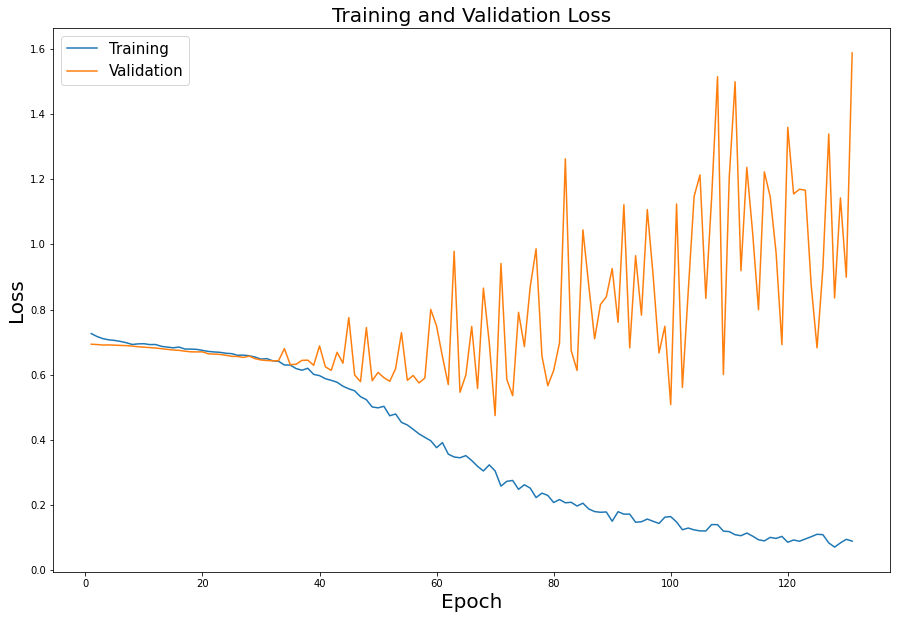

In [385]:
plt.figure(figsize=(15,10))
plt.plot(epoch_nums_, training_loss_)
plt.plot(epoch_nums_, validation_loss_)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(['Training', 'Validation'],  prop={"size":15})
plt.title('Training and Validation Loss', fontsize=20)
plt.show()


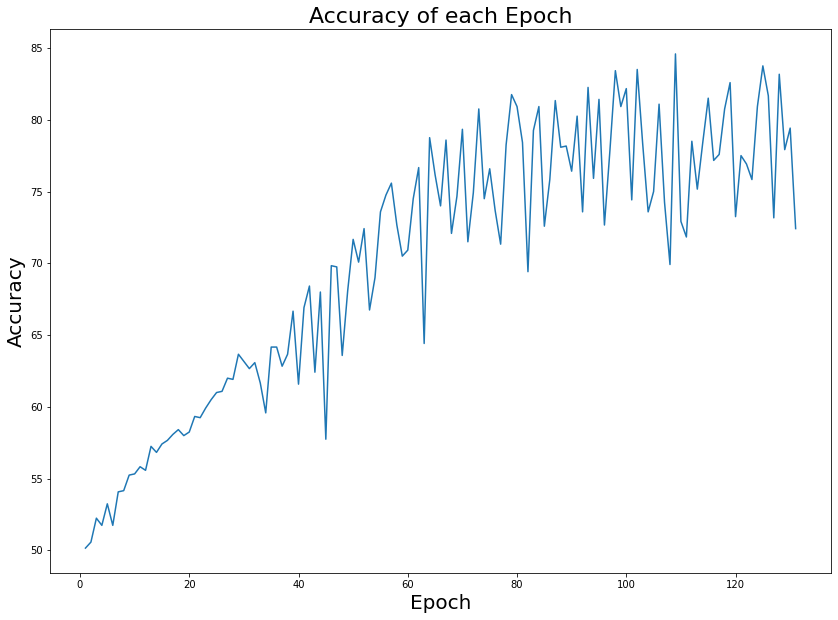

In [386]:
import matplotlib.transforms as transforms
import matplotlib.ticker as mtick

fig, ax=plt.subplots()
ax.plot(epoch_nums_, validation_predict_)
plt.title('Accuracy of each Epoch', fontsize=22)
fig.set_size_inches(14, 10)

ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)
plt.show()

# Test

In [205]:
def generate_testing_pairing(pairing_size, normalized_training_data):
    
    test_pairs = []
    scaling = 100//pairing_size
    phase_shift = (pairing_size - 1 ) // 2

    for i in range(int(len(normalized_training_data['proteins']))):
        test_pairs_ = torch.zeros(2,pairing_size,pairing_size,pairing_size)
        
        # Protein
        for j in range(len(normalized_training_data['proteins'][i][0])):
            x_p, y_p, z_p = normalized_training_data['proteins'][i][0][j], normalized_training_data['proteins'][i][1][j], normalized_training_data['proteins'][i][2][j]
            x_p, y_p, z_p = int(round(x_p/scaling + phase_shift)), int(round(y_p/scaling + phase_shift)), int(round(z_p/scaling + phase_shift))

            # Pruning 
            if x_p >= pairing_size or y_p >= pairing_size or z_p >= pairing_size or x_p < 0 or y_p < 0 or z_p < 0 :
                continue
            if test_pairs_[0,x_p,y_p,z_p] !=0 or test_pairs_[1,x_p,y_p,z_p] !=0:
                continue
                
            # First channel
            test_pairs_[0,x_p,y_p,z_p] = -1
            
            # Second channel
            if normalized_training_data['proteins'][i][3][j] == 'h':
                test_pairs_[1,x_p,y_p,z_p] = 1
            else:
                test_pairs_[1,x_p,y_p,z_p] = -1
                
        test_pairs.append(test_pairs_)  
        
    return test_pairs


In [384]:
# Generate protein pairs for testing data
testing_pairs = generate_order_pairing(25, norm_test_data)
testing_tensor = torch.stack(testing_pairs)
print('Shape of disorder_training_pairs:',disorder_training_pairs.shape)
print('Shape of disorder_validation_pairs:',disorder_validation_pairs.shape)


Shape of testing_pairs: torch.Size([2, 25, 25, 25])
Shape of testing_tensor: torch.Size([824, 2, 25, 25, 25])


In [449]:
model = torch.load('model_80.pt')
top10_list = []

def OutputFile(top10_list):
    np_top10_list=np.array(top10_list)
    test_prediction=pd.DataFrame({'pro_id':np_top10_list[:,0]})
    for i in range(1,11):
        test_prediction['lig{}_id'.format(i)]=np_top10_list[:,i]
    return test_prediction


for i in range(825):
    pred = model(testing_tensor)[:,1]
    dict_ = {'idx': i, 'pro': list(pred.data.numpy())}
    top10_idx = pd.DataFrame(dict_).sort_values(by='pro', ascending=False).head(10).index
    top10_list.append([i] + list(top10_idx))
    
    
    
test_prediction=OutputFile(top10_list)
test_prediction.to_csv('test_prediction.txt',sep='\t', index=False)

